In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
def compress_xy(x,y,CONST):
    return y * CONST + x

In [3]:
def extract_xy(compress,CONST):
    return [compress % CONST, int(compress / CONST)]

In [4]:
def find_skeleton_centers(cell_count, gradient_total, threshold, regs_label):
    centers = []
    for i in range(cell_count+1):
        masked = (regs_label == i) & (gradient_total < threshold)
        if not np.any(masked):
            continue
        #Skeleton of this cell
        y = np.ma.array(gradient_total * masked)
        row_indices, col_indices = np.where(y < 0)
        if(len(row_indices)<1):
            original_field = (regs_label == i)
            row_indices, col_indices = np.ma.where(original_field)
        #Find the geomerty center
        x_center = np.mean(row_indices)
        y_center = np.mean(col_indices)
        #Projected the geomerty center on skeleton
        distances = np.sqrt((row_indices - x_center)**2 + (col_indices - y_center)**2)
        closest_index = np.argmin(distances)
        closest_point = (row_indices[closest_index], col_indices[closest_index])
        #Found skeleton center
        centers.append(compress_xy(closest_point[1], closest_point[0], DIGIT))
        
    return centers

In [5]:
def flow_to_ends(start_points, gradient_total,threshold):
    #Don't pollute original data
    start_points_copy = start_points.copy()
    gradient_total_copy = gradient_total.copy()
    masked_array = gradient_total_copy < threshold
    #Point set is the set flow go through 
    point_set = set(start_points_copy)
    end_point = []
    while point_set:
        newset = set()
        for element in point_set:
            [xx,yy] = extract_xy(element,DIGIT)
            #DO waterfront
            waterfront_set = set([element -1 , element +1, element - DIGIT +1, element + DIGIT +1, element + DIGIT -1, element - DIGIT -1, element + DIGIT, element - DIGIT])
            flag = False
            for each in waterfront_set:
                [x,y] = extract_xy(each,DIGIT)
                if ((x < 0) or (y < 0) or (y >= len(masked_array)) or (x >= len(masked_array[0]))):
                    continue
                else:
                    if (masked_array[y,x] == True ):
                        newset.add(each)
                        flag = True
            if flag == False:
                end_point.append(element)
            masked_array[yy,xx] = False

        #Mask the pixels out when the whole waterfront of pixels iterated, so won't self eated. 
        for each in newset:
            [x,y] = extract_xy(each,DIGIT)
            masked_array[y,x] = False
            
        point_set = newset

    return end_point

In [6]:
def get_masked_skeleton(cell_number, gradient_total, regs_label, threshold):
    masked = (gradient_total < threshold)
    if(cell_number != -1): 
        masked = masked & (regs_label == cell_number)
    masked_skeleton = np.ma.array(gradient_total * masked)
    return masked_skeleton

In [7]:
def find_muti_ends(ends_count, cell_count, centers, gradient_total,threshold, regs_label):
    all_ends = []
    for time in range(ends_count):
        current_start = centers if time == 0 else all_ends
        result_ends = flow_to_ends(current_start, gradient_total,threshold)
        for i in range(1,cell_count+1):
            mask =  (gradient_total < threshold) & (regs_label == i)
            current_result = -1
            for element in result_ends:
                [x,y] = extract_xy(element,DIGIT)
                if(mask[y,x] == True):
                    current_result = element
            if(current_result != -1): 
                all_ends.append(current_result)
    return all_ends

In [8]:
def calculate_local_slop(point, radius,gradient_total,regs_label, threshold):
    [x,y] = extract_xy(point,DIGIT)
    #+1 here is only for boundary condition
    x_array = []
    y_array = []
    # get the masks 
    cell_number = regs_label[y,x]
    mask = (gradient_total < threshold) & (regs_label == cell_number)
    for xi in range(max(x-radius,0), min(x+radius+1,len(gradient_total[0]))):
        for yi in range(max(y-radius,0),min(y+radius+1,len(gradient_total))):
            if (np.sqrt((xi-x)**2 + (yi-y)**2) <= radius) and (mask[yi,xi]):
                x_array.append(xi)
                y_array.append(yi)
    return [x - np.mean(x_array), y - np.mean(y_array)]

In [11]:
#Skeleton field
dat = np.load('211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00001xy0c1_seg.npy', allow_pickle=True).item()
gradientsx = np.gradient(dat['flows'][-1][0])
gradientsy = np.gradient(dat['flows'][-1][1])
gradient_total = gradientsy[1] + gradientsx[0]

#Cell masks field
mat = scipy.io.loadmat('regs_label.mat')
regs_label = mat['regs'][0][0][0]

#Const digit
DIGIT = 100000
CONST = 100000

In [9]:
def work(npy_path):
    dat = np.load(npy_path, allow_pickle=True).item()
    gradientsx = np.gradient(dat['flows'][-1][0])
    gradientsy = np.gradient(dat['flows'][-1][1])
    gradient_total = gradientsy[1] + gradientsx[0]
    regs_label = dat['masks']
    cell_num = np.max(regs_label)
    centers = find_skeleton_centers(cell_num, gradient_total, -3, regs_label)
    all_ends = find_muti_ends(2, cell_num, centers, gradient_total,-3, regs_label)
    trans_array = np.zeros([len(regs_label[0]),len(regs_label),3])
    for each in all_ends:
        [x,y] = extract_xy(each,DIGIT)
        [vx,vy] = calculate_local_slop(each, 10,gradient_total,regs_label, -3)
        trans_array[x,y] = [vx,vy,1]
    data = {'vector': trans_array, 'skeleton':gradient_total}
    mat_filename = npy_path.replace('_seg.npy', '_track.mat')
    savemat(mat_filename, data)  

In [12]:
DIGIT = 100000
CONST = 100000

In [ ]:
def store_imag(npy_path):
    image = plt.imshow(gradient_total, cmap='Greys')
    
    plt.xlim(0,2560)
    plt.ylim(0,2160)
    
    plt.gca().invert_yaxis()
    
    for each in all_ends:
        [x,y] = extract_xy(each,DIGIT)
        plt.scatter(x, y, c='red', marker='o')
        [vx,vy] = calculate_local_slop(each, 30,gradient_total,regs_label, -1)
        plt.arrow(x, y, vx*2, vy*2, head_width = 5, width = 0.5, ec ='black')
    image_filename = npy_path.replace('_seg.npy', '.png')
    image_filename = image_filename.replace('xy0/phase', 'images')
    plt.savefig(image_filename)

In [13]:
from scipy.io import savemat
import numpy as np
import glob
import os
npzFiles = glob.glob("/Users/sherryyang/wigginsLab/data/half_raw/xy0/phase/*.npy")
for f in npzFiles:
    work(f)

In [ ]:
npzFiles = glob.glob("/Users/sherryyang/wigginsLab/data/0814/xy0/phase/*.npy")
for f in npzFiles:
    print(f)


In [30]:
os.path.join(image_folder, image_filenames[1])

'/Users/sherryyang/wigginsLab/data/manually_fixed/t00001.tif'

In [38]:
import os
import cv2
import numpy as np

# Path to the folder containing your images
image_folder = '/Users/sherryyang/wigginsLab/data/0722/images'

# Get a list of image filenames sorted alphabetically
image_filenames = sorted(os.listdir(image_folder))

# Read the first image to get its dimensions
base_image = cv2.imread(os.path.join(image_folder, image_filenames[0]), cv2.IMREAD_UNCHANGED)
height, width, channels = base_image.shape

# Create an empty numpy array to store the accumulated result
result = np.zeros((height, width, channels), dtype=np.uint16)

# Loop through the sorted image filenames and accumulate the images
for image_filename in image_filenames:
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    result = image + result



In [ ]:
result = result/np.max(result) * 255
plt.imshow(result, cmap='Greys')

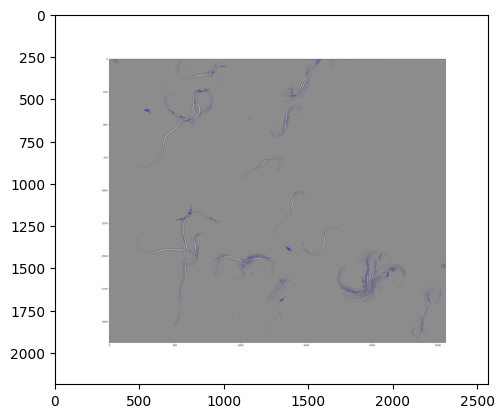

In [54]:
plt.imshow((1.000 * result)/float(np.max(result)))

In [37]:
result

array([[[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]],

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]],

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]],

       ...,

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]],

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        .

In [7]:
work('211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00032xy0c1_seg.npy')

NameError: name 'work' is not defined

In [ ]:
result_ends = flow_to_ends(centers, gradient_total,-1)

In [56]:
centers = find_skeleton_centers(42, gradient_total, -1, regs_label)

In [129]:
all_ends = find_muti_ends(2, 42, centers, gradient_total,-1, regs_label)

In [120]:
ends = flow_to_ends(centers, gradient_total,-1)

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25.63, 21.87))
image = plt.imshow(gradient_total, cmap='Greys')
for each in all_ends:
    [x,y] = extract_xy(each,DIGIT)
    plt.scatter(x, y, c='red', marker='o')
    [vx,vy] = calculate_local_slop(each, 30,gradient_total,regs_label, -1)
    plt.arrow(x, y, vx, vy, head_width = 2, width = 0.5, ec ='black')

NameError: name 'gradient_total' is not defined

<Figure size 2563x2187 with 0 Axes>

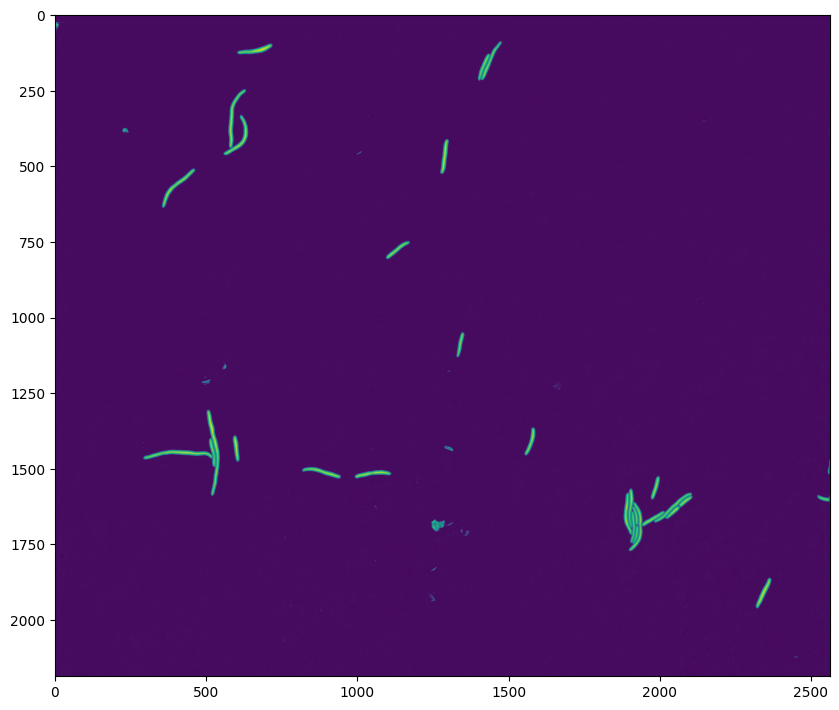

In [191]:
dat = np.load('211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00001xy0c1_seg.npy', allow_pickle=True).item()
plt.figure(figsize=(10, 10))
plt.imshow(dat['flows'][-1][2])